# 02 - Tabular Regression

<div class="alert alert-block alert-success">  
 <b>Version:</b> v0.1 <b>Date:</b> 2020-06-10
  
使用`fastai v2`解决表格数据的回归问题案例。 
</div>


<div class="alert alert-block alert-info">
<b>💡:</b> 

- **环境依赖**： Fastai v2 (0.0.18)
- **数据集**：[Rossmann](https://www.kaggle.com/init27/fastai-v3-rossman-data-clean) 
</div>

## Rossmann

Rossmann's Kaggle competition was a business sales prediction competition for $35,000 dollars to the winners.

The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future.

We can do this through a tabular regression model.

Jeremy walks through feature engineering for this problem, for today though we will download a clean engineered dataset straight from Kaggle. To download it:
1. Go to: https://www.kaggle.com/init27/fastai-v3-rossman-data-clean
2. Go to `output`
3. Right click the download button
4. Click "copy link location" for both train and test
5. `!wget {url}`

(Note: to walk through the feature engineering, see [this](https://github.com/fastai/fastai2/blob/master/nbs/course/rossman_data_clean.ipynb) notebook)

In [ ]:
train = 'ENTER_URL_HERE'
test = 'ENTER_URL_HERE'

In [ ]:
!wget {train} -q
!wget {test} -q

# Time-Series Analysis

In [1]:
from fastai2.tabular.all import *

## The Data:

In [5]:
from pathlib import *

In [10]:
path = Path("/home/inesa-gao/.fastai/data/rossmann/")

In [11]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [12]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [14]:
len(train_df.columns)

93

With our time-series based approach, the feature engineering made a bunch of date-related categorical columns that we can utilize in our **embeddings**.

In [15]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']
   
dep_var = 'Sales'

When doing Regression with these large numbers, we often use the **log** of these values for our `y`'s. Let's transform them real quick:

In [16]:
train_df[dep_var] = np.log(train_df[dep_var])

Now let's declare our `procs`

In [17]:
procs = [FillMissing, Normalize, Categorify]

And splits. Now we want to ensure that (since this is time series) our validation and test 

In [18]:
len(train_df), len(test_df)

(844338, 41088)

In [19]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

Let's find that particular index

In [21]:
train_df['Date'][0]

Timestamp('2015-07-31 00:00:00')

In [22]:
idx = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

In [23]:
idx

41395

So now our `splits` will be every index *after* the 41395'th item

In [24]:
splits = (L(range(idx, len(train_df))),L(range(idx)))

In [25]:
splits

((#802943) [41395,41396,41397,41398,41399,41400,41401,41402,41403,41404...],
 (#41395) [0,1,2,3,4,5,6,7,8,9...])

Let's make our `TabularPandas`! Since we have a large `DataFrame`, we can enable `inplace` to `True` and `reduce_memory` to `True` to save on some storage space (**Note**: `reduce_memory` is by default `True`). To use `inplace`, we need to set `chained_assignment` to `None` in `pandas`

In [26]:
pd.options.mode.chained_assignment=None

In [27]:
to = TabularPandas(train_df, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                   splits=splits, inplace=True, reduce_memory=True)

And now let's build our `dataloaders`!

In [28]:
dls = to.dataloaders(bs=512)

In [29]:
dls.show_batch()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,Promo,SchoolHoliday,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
0,712,4,2015,1,8,False,24,25,a,a,"Jan,Apr,Jul,Oct",2007,2009,BY,2,Rain,5,4,0,1,0,2,1,0,False,False,4869.999990,9.0,4.0,1.530432e-07,100.0,82.000000,66.000000,57.999999,14.0,7.0,69.0,67.0,1.999998,-85.000001,8.835211
1,275,1,2014,6,16,False,1,0,d,a,"Jan,Apr,Jul,Oct",2014,2014,BY,25,#na#,5,1,1,0,5,5,1,1,False,False,300.000067,21.0,16.0,1.000000e+01,82.0,59.000000,35.000000,14.000000,10.0,2.0,58.0,62.0,6.999999,-3.000002,8.954028
2,281,6,2014,6,14,False,24,0,d,c,#na#,2011,1900,SH,24,Rain,5,0,0,1,0,0,0,0,False,False,6969.999977,20.0,16.0,1.200000e+01,94.0,64.000000,30.000000,26.000000,13.0,5.0,61.0,75.0,5.000001,-111.000004,8.570924
3,988,2,2013,6,4,False,6,0,a,a,#na#,2012,1900,SH,23,#na#,4,5,0,0,0,0,1,0,False,False,30.000061,18.0,14.0,1.100000e+01,88.0,61.000000,39.000000,26.000000,16.0,2.0,50.0,55.0,14.999999,-121.000002,8.693161
4,740,4,2013,6,13,False,0,0,d,a,#na#,2014,1900,HE,24,Rain,3,1,0,0,0,0,0,0,False,False,6400.000023,27.0,21.0,1.400000e+01,100.0,68.000000,33.999999,33.999999,11.0,6.0,68.0,67.0,14.000000,-111.999999,8.446342
5,501,5,2013,7,12,False,24,0,a,c,#na#,2006,1900,BY,28,Fog,4,0,0,0,0,0,0,0,False,False,1620.000095,22.0,14.0,8.000000e+00,100.0,67.000000,38.000000,13.000000,6.0,2.0,65.0,67.0,43.000000,-34.000000,8.488382
6,771,5,2013,5,3,False,24,0,a,a,#na#,2007,1900,BY,18,Rain,1,5,1,1,0,0,1,0,False,False,20639.999570,15.0,13.0,1.100000e+01,100.0,88.000000,76.999999,21.000000,11.0,6.0,55.0,56.0,1.999998,-6.000001,8.914761
7,23,2,2014,7,8,False,24,0,d,a,#na#,2005,1900,RP,28,Rain,1,3,0,0,0,0,0,0,False,False,4060.000031,19.0,17.0,1.400000e+01,97.0,90.000001,81.000000,19.000000,10.0,7.0,67.0,73.0,18.999999,-86.999999,8.313117
8,682,3,2013,7,3,False,24,0,b,a,#na#,2006,1900,BE,27,Thunderstorm,3,3,0,0,5,5,1,1,False,False,150.000064,28.0,22.0,1.600000e+01,82.0,56.999999,30.000000,26.000000,13.0,6.0,75.0,58.0,44.000000,-91.999999,9.464362
9,50,4,2015,5,21,False,24,0,d,a,#na#,2009,1900,RP,21,#na#,2,4,1,0,0,0,1,0,False,False,6260.000020,18.0,11.0,4.000000e+00,95.0,50.000000,19.000000,19.000000,10.0,3.0,69.0,70.0,6.999999,-4.000001,8.380457


## The Model:


As we're doing regression, we want to dictate what the maximum value to be (and minimum) so we will use a `y_range`

In [33]:
dls.train.y.max()

10.56416319294911

In [35]:
max_log_y = np.max(train_df['Sales'])*1.2

In [36]:
max_log_y

12.7616122408592

And now we can make a `y_range`

In [37]:
y_range = torch.tensor([0, max_log_y]); y_range

tensor([ 0.0000, 12.7616], dtype=torch.float64)

Next comes our `Learner`. We'll walk through each step

In [38]:
learn = tabular_learner(dls, layers=[1000,500], ps=[0.001, 0.01],
                       embed_p=0.04, y_range=y_range, metrics=exp_rmspe,
                       loss_func=MSELossFlat())

So we have a lot going on right there. `ps` is overall dropout (helps with overfitting), `embed_p` is dropout on the embedding weights, `exp_rmspe` is Root Mean Square Percentage Error

Let's look at our model:

In [39]:
learn.summary()

TabularModel (Input shape: ['512 x 26', '512 x 14'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            512 x 81             90,396     True      
________________________________________________________________
Embedding            512 x 5              40         True      
________________________________________________________________
Embedding            512 x 3              12         True      
________________________________________________________________
Embedding            512 x 7              91         True      
________________________________________________________________
Embedding            512 x 11             352        True      
________________________________________________________________
Embedding            512 x 3              9          True      
________________________________________________________________
Embedding            512 x 10             260        True      
_____________________________________________

## Training

Now let's fit!

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0003311311302240938)

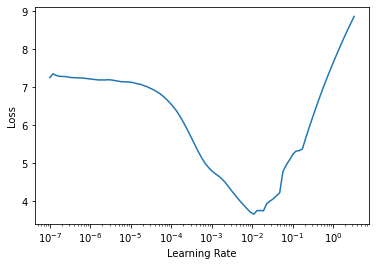

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.024659,0.033440,0.165258,00:29
1,0.014117,0.015768,0.136954,00:29
2,0.010565,0.012690,0.113846,00:29
3,0.007774,0.011494,0.109941,00:29
4,0.006334,0.011417,0.108200,00:29


For comparison, an `exp_rmspe` of 0.108 was 10th place

## Inference on a test set:
Now that we have a model, we want to make our final competitions that would be submitted to a competition, as such, we can only make the predictions and submit them as a CSV.

We'll practice bringing in an exported model just to show that you do not need the original data. 

In [42]:
learn.export('myModel')

In [ ]:
del learn

In [ ]:
learn = load_learner('myModel')

Now we generate our `test_dl` from our `test_df`

In [43]:
test_dl = learn.dls.test_dl(test_df)

We need to tell the `Learner` to return the predictions for the test set we added

In [44]:
raw_test_preds = learn.get_preds(dl=test_dl)

Let's take a peek

In [45]:
raw_test_preds

(tensor([[ 8.3493],
         [ 8.8604],
         [ 9.1918],
         ...,
         [ 8.7052],
         [10.0084],
         [ 8.8697]]),
 None)

You'll notice `[0]` contains our predictions, and `[1]` contains any labels (if we had any). This is nice because if we accidently run `learn.validate()` on a non-labeled test set, we get the following:

In [ ]:
learn.validate(dl=test_dl)

(#2) [None,None]

Still runs, just there are no labels so it's `None`

Now back to our predictions! We need to undo our `log` transform first:

In [46]:
np.exp(raw_test_preds[0])

tensor([[ 4227.0649],
        [ 7047.5244],
        [ 9816.0527],
        ...,
        [ 6034.1582],
        [22212.4141],
        [ 7113.4956]])

In [47]:
test_preds = np.exp(raw_test_preds[0]).numpy().T[0]

(If you want to learn about what `T` does, compare below):

In [ ]:
raw_test_preds[0].numpy()

array([[ 8.380785],
       [ 8.878132],
       [ 9.18451 ],
       ...,
       [ 8.750105],
       [10.040629],
       [ 8.921454]], dtype=float32)

In [ ]:
test_preds

array([ 4362.432 ,  7173.3774,  9745.006 , ...,  6311.35  , 22939.816 ,
        7490.9766], dtype=float32)

Now we can submit to Kaggle!

In [48]:
test_df['Sales'] = test_preds
test_df[['Id', "Sales"]] = test_df[['Id', 'Sales']].astype('int')

And finally we make our submission. **NOTE:** remove the index when generating your submission always!

In [49]:
test_df[['Id', 'Sales']].to_csv('submission.csv', index=False)